## Classificação tipo - Medicamento

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
df = pd.read_csv("combustivel-medicamentos-500mil.csv")

In [3]:
df.head()

,codigoNCMProduto,codigoCESTProduto,descricaoProduto,tipo,subtipo
0,85362000,0106700,DISJUNTOR UNIPOLAR DE 25A,NaN,NaN
1,85362000,0106700,DISJUNTOR UNIPOLAR DE 32A,NaN,NaN
2,85437099,0900500,LAMPADA BULB LED DE 9 5W A 60,NaN,NaN
3,27101921,0600600,DIESEL COMUM B S10 DS10,COMBUSTIVEL,DIESEL S10
4,61091000,SEM CEST,CAMISAS EM MALHA PIQUET,NaN,NaN


In [4]:
df.shape

(2800000, 5)

In [5]:
df.isnull().sum() # todos os campos de descrição estão preenchidos

codigoNCMProduto           0
codigoCESTProduto          0
descricaoProduto           0
tipo                 1870409
subtipo              1871870
dtype: int64

### Mudando tipo para Medicamento = 1 e Não Medicamento = 0

In [6]:
df['tipo'].unique() # valores exitentes na coluna

array([nan, 'COMBUSTIVEL', 'MEDICAMENTO'], dtype=object)

In [7]:
def med_1_nmed_0(valores):                          # o que for medicamento será 1 e não medicamento 0
    copy_valores = valores.copy()

    for i in range(len(copy_valores)):
        if copy_valores[i] == 'MEDICAMENTO':
            copy_valores[i] = 1
        else:
            copy_valores[i] = 0
    
    return copy_valores

In [8]:
df['tipo'] = med_1_nmed_0(df['tipo'].values)
np.unique(df['tipo'].values, return_counts=True) # mostra os novos valores na coluna e a contagem de cada valor

(array([0, 1], dtype=object), array([2509286,  290714], dtype=int64))

### Reduzindo quantidade de Não Medicamentos para igualar a quantidade de amostras

In [9]:
qtde_0, qtde_1 = df['tipo'].value_counts().values # retornando a contagem dos valores de Medicamentos e Não Medicamentos

diferenca = qtde_0 - qtde_1

print(f'Quantidade de Não Medicamentos: {qtde_0}')
print(f'Quantidade de Medicamentos: {qtde_1}')
print(f'Diferença: {diferenca}')

Quantidade de Não Medicamentos: 2509286
Quantidade de Medicamentos: 290714
Diferença: 2218572


In [10]:
indices_valores_0 = df[df['tipo'] == 0].index.values # pegando o índice da linha de todos os valores 0 (Não Medicamento) e transformando em array com o '.values'
indices_valores_0

array([      0,       1,       2, ..., 2799997, 2799998, 2799999],
      dtype=int64)

In [11]:
import random

random.shuffle(indices_valores_0) # embaralhando a ordem dos indices
indices = indices_valores_0[:diferenca] # pegando quantidade certa para eliminar a diferença entre amostras
len(indices) == diferenca

True

In [12]:
df_reduzido = df.drop(indices) # deletando linhas

In [13]:
#Verificando se nova base está igualada
qtde_0_nova, qtde_1_nova = df_reduzido['tipo'].value_counts().values # retornando a contagem dos valores de Medicamentos e Não Medicamentos

diferenca_nova = qtde_0_nova - qtde_1_nova

print(f'Quantidade de Não Medicamentos: {qtde_0_nova}')
print(f'Quantidade de Medicamentos: {qtde_1_nova}')
print(f'Diferença: {diferenca_nova}')

Quantidade de Não Medicamentos: 290714
Quantidade de Medicamentos: 290714
Diferença: 0


In [14]:
del qtde_0, qtde_1, diferenca, df, qtde_0_nova, qtde_1_nova, diferenca_nova
gc.collect()

0

### Salvando nova base

In [15]:
df_reduzido.to_csv(r'Base_Treinamento_Igualada.csv', sep=';', index=False) # Salvando nova base de treinamento

### Carregando nova base

In [16]:
df_reduzido = pd.read_csv(r'Base_Treinamento_Igualada.csv', sep=';')
df_reduzido

,codigoNCMProduto,codigoCESTProduto,descricaoProduto,tipo,subtipo
0,85362000,0106700,DISJUNTOR UNIPOLAR DE 25A,0,NaN
1,34013000,SEM CEST,SABONETE LIQUIDO 1L,0,NaN
2,27101932,0600500,MOTORCRAFT SYNTHETIC 5W30 24X1L 122222,0,NaN
3,8109015,SEM CEST,MARACUJA,0,NaN
4,30042069,1300400,ESKAVIT 10MG ML C 50 AMP 1ML HIP HIPOLABOR HOSP,1,VITAMINA K SIMPLES OU EM ASSOCIACOES MEDICAMEN...
...,...,...,...,...,...
581423,27101259,0600200,GASOLINA COMUM XGCX,0,GASOLINA COMUM
581424,30049039,1300400,BRONQTRAT XPE ADULTO C 120ML NATUL,1,EXPECTORANTES BALSAMICOS E MUCOLITICO
581425,30049099,SEM CEST,SIMETICONA 40MG C 20 COMP MULTI,1,ADSORVENTES E ANTIFISETICOS INTESTINAIS SIMPLES
581426,18069000,1700400,BONBONS GAROTO SORT 250G,0,NaN


### Divisão atributos e classificação

In [17]:
x = df_reduzido['descricaoProduto'].values
y = df_reduzido['tipo'].values

### Limpeza de Texto

In [18]:
x_copy = x.copy()
y_copy = y.copy()
print(x_copy)
print()
print(len(x_copy))

['DISJUNTOR UNIPOLAR DE 25A' 'SABONETE LIQUIDO 1L'
 'MOTORCRAFT SYNTHETIC 5W30 24X1L 122222' ...
 'SIMETICONA 40MG C 20 COMP MULTI ' 'BONBONS GAROTO SORT 250G'
 'GLP ENVAZADO EM BOTIJAODE 45KG ']

581428


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

stopwords = nltk.corpus.stopwords.words('portuguese') # stopwords do português
count_vectorizer = CountVectorizer(stop_words=stopwords)
remove_stopwords = count_vectorizer.build_analyzer() # função para remover as stopwords

In [20]:
import re
from unidecode import unidecode

def LimpezaTexto(textos: list[str]) -> list[str]:
    """
    Recebe uma lista de strings, faz uma limpeza no texto retirando acentos,
    letras maiúsculas, tudo que não é letra ou número, espaços duplos, stopwords,
    entre outras coisas.
    """
    textos_copy = textos.copy()

    for i in range(len(textos_copy)):
        descricao = unidecode(textos_copy[i].lower())                           # padronizar em palavras sem acentos e letras minúsculas
        descricao = re.sub(r'[^a-zA-Z0-9_ ]','', descricao)                     # retirar tudo que não é letra, número ou espaço
        descricao = re.sub(r'[0-9]{6,}','', descricao)                          # retirar sequências numéricas com quantidade de algarismos maior que 6
        descricao = re.sub(r'\b[a-z]{1,2}\b','', descricao)                     # retirar letras e pares de letras sozinhas
        descricao = re.sub(r'\b[a0-9]{1,2}\b','', descricao)                     # retirar numeros e pares de numeros sozinhos
        descricao = ' '.join([word for word in remove_stopwords(descricao)])    # retirar stopwords / retirar duplo espaço / retirar espaços começo e final da string
                    # realizado desse jeito pois 'count_vectorizer.build_analyzer()'/'remove_stopwords' retorna as palavras da descrição separadas em uma lista
        textos_copy[i] = descricao
    
    return textos_copy

In [21]:
x_copy = LimpezaTexto(x_copy)
del stopwords, count_vectorizer, remove_stopwords
gc.collect()

7

#### Análise Descrições

In [14]:
# total=''
# for frase in x_copy:                # juntando todas as descrições
#     total += frase + ' '

# palavras = re.findall(r'\w+',total) # pegando todas as palavras das descrições separadamente
# print('Quantidade de palavras sem contar as repetições:', len(np.unique(palavras)), '\nQuantidade total de palavras:', len(palavras))

In [15]:
# from collections import Counter
# palavras_count = Counter(palavras) # contando a frequencia de cada palavra
# palavras_count.most_common(30)     # as 30 palavras mais comuns e suas contagens

### Visualizando amostras aleatórias

In [25]:
import random

indice_aleatorio = random.randint(0,len(x_copy)-1) # retorna um inteiro aleatorio entre o intervalo definido
x_copy[indice_aleatorio]

'bronquivita composto 150ml'

### Dividindo em treino, validação e teste

In [26]:
from sklearn.model_selection import train_test_split

x_treino, x_temp, y_treino, y_temp = train_test_split(x_copy, y_copy, test_size=0.2, random_state=42, stratify=y_copy)   # dividindo em 80% para treino e 20% para validação e teste
x_valid, x_teste, y_valid, y_teste = train_test_split(x_temp, y_temp, test_size= 0.5, random_state=42, stratify=y_temp)  # dividindo meio a meio os 20% anteriores em validação e teste
print(f'Quantidade treino x: {len(x_treino)}\nQuantidade treino y: {len(y_treino)}\n80%\n\n')
print(f'Quantidade validação x: {len(x_valid)}\nQuantidade validação y: {len(y_valid)}\n10%\n\n')
print(f'Quantidade teste x: {len(x_teste)}\nQuantidade teste y: {len(y_teste)}\n10%')

# Convertendo para tensor tipo float32. Caso não seja feita essa conversão seguiria com outro tipo de inteiro ou float provocando um erro na rede neural / formato mais seguro para processar em tensorflow é float32
x_treino, y_treino = tf.constant(x_treino), tf.constant(y_treino, dtype=tf.float32)
x_valid, x_teste, y_valid, y_teste = tf.constant(x_valid), tf.constant(x_teste), tf.constant(y_valid, dtype=tf.float32), tf.constant(y_teste, dtype=tf.float32)

Quantidade treino x: 465142
Quantidade treino y: 465142
80%


Quantidade validação x: 58143
Quantidade validação y: 58143
10%


Quantidade teste x: 58143
Quantidade teste y: 58143
10%


### Salvando Treino, Validação e Teste

In [27]:
import pickle
pickle.dump([x_treino, x_valid, x_teste, y_treino, y_valid, y_teste],
            open(r'Treino_Val_Teste.pkl', 'wb'))

### Carregando Treino, Validação e Teste

In [28]:
import pickle
x_treino, x_valid, x_teste, y_treino, y_valid, y_teste = pickle.load(open(r'Treino_Val_Teste.pkl', 'rb'))
len(x_treino), len(x_valid), len(x_teste), len(y_treino), len(y_valid), len(y_teste)

(465142, 58143, 58143, 465142, 58143, 58143)

### Convertendo texto em números (Tokenization)

Precisa definir o comprimento máximo de palavras por 'frase' (descrição da nota) como também a quantidade máxima de palavas (tokens) a serem armazenadas no vocabulário

In [29]:
# Quantidade de palavras na frase será definida pela média de palavras em cada descrição
comprimento_max_descricao = round(sum([len(descricao.split()) for descricao in x_copy])/len(x_copy))
          # pegando cada descrição e separando as palavras em uma lista
          # criando uma lista da quantidade de palavras em cada descrição
          # somando todos os valores e dividindo pela quantidade de descrições para obter a média
          # arredondando o valor

max_palavras = 10_000
comprimento_max_descricao, max_palavras

(4, 10000)

In [30]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_palavras,
                                    output_mode="int",
                                    output_sequence_length=comprimento_max_descricao) # criando camada de vetorização da rede neural

text_vectorizer.adapt(x_treino) # treinando a camada para o vocabulário em questão

In [31]:
# exemplo
text_vectorizer([x_teste[0]])

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[1463,  320, 1555,    2]], dtype=int64)>

In [32]:
# Palavras gravadas no vocabulário
palavras_vocab = text_vectorizer.get_vocabulary()
palavras_vocab[:5], palavras_vocab[-5:]

(['', '[UNK]', 'comp', 'gasolina', 'comum'],
 ['magnet', 'maglumi', 'madri', 'madei', 'macrosul'])

In [33]:
# como definido anteriormente o vocabulário possui 10_000 palavras
len(palavras_vocab)

10000

### Salvando Tokenizer

In [34]:
import pickle
pickle.dump({'config': text_vectorizer.get_config(),       # Salvando configuração e pesos do tokenizer
             'weights': text_vectorizer.get_weights()},
             open(r'tokenizer.pkl', 'wb'))

### Carregando Tokenizer

In [35]:
from tensorflow.keras.layers import TextVectorization
import pickle

tokenizer_disco = pickle.load(open(r'tokenizer.pkl', 'rb'))

tokenizer = TextVectorization.from_config(tokenizer_disco['config'])      # Carregando configuração e pesos
tokenizer.set_weights(tokenizer_disco['weights'])

In [36]:
print(text_vectorizer([x_teste[0]]) == tokenizer([x_teste[0]]))
print(tokenizer([x_teste[0]]))

tf.Tensor([[ True  True  True  True]], shape=(1, 4), dtype=bool)
tf.Tensor([[1463  320 1555    2]], shape=(1, 4), dtype=int64)


### Normalização dos valores dos tokens (Embedding)

In [37]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_palavras,
                      output_dim=128,                           # tamanho do vetor de embedding dos tokens
                      embeddings_initializer='uniform',         # inicializa o processo de embedding de forma aleatória
                      input_length=comprimento_max_descricao)

embedding

In [38]:
# exemplo
embedding(tokenizer([x_teste[0]])), embedding(tokenizer([x_teste[0]])).shape

(<tf.Tensor: shape=(1, 4, 128), dtype=float32, numpy=
 array([[[ 0.02238579, -0.01208594,  0.00434441,  0.00457975,
           0.0287982 , -0.01622611,  0.04046107, -0.02684838,
          -0.02087008,  0.02355098, -0.02500378, -0.02813484,
          -0.04601977, -0.02604192,  0.01645315, -0.04798354,
           0.02584405,  0.00902743, -0.01768128,  0.04987146,
           0.01685014, -0.01629   , -0.0025462 , -0.00901785,
           0.03434999, -0.04095609,  0.04481057,  0.03590382,
           0.00916526, -0.01734203,  0.00017139, -0.00275417,
          -0.04551498, -0.01717158,  0.00718691,  0.04283679,
          -0.01734229,  0.03393296, -0.02390834,  0.03888797,
           0.04082913,  0.03237063, -0.00010828,  0.0217703 ,
           0.03979761, -0.01050345,  0.01492094,  0.04529131,
          -0.03843592,  0.03990621,  0.00739876, -0.04298587,
           0.0460331 , -0.0495652 , -0.01986287,  0.01091865,
          -0.0003407 , -0.04954263, -0.00398642,  0.0257641 ,
           0.002

## Redes Neurais

#### Função plotar curvas validação e precisão

In [40]:
def plot_val_accuracy(history, save=True, ticks=True):
    plt.figure(figsize=(10,7))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    if ticks:
        plt.yticks(tf.range(0, 1.1, delta=0.1, dtype=tf.float32))
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    if ticks:
        plt.yticks(tf.range(0, 1.1, delta=0.1, dtype=tf.float32))
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()

    if save:
        plt.savefig(r'Accuracy_Loss.png', format='png')

### Rede Neural Recorrente LSTM (Long Short-Term Memory)
>Entrada (texto) -> Tokenize -> Embedding -> Layers (RNN's/dense) -> Saída (probabilidade da classificação)


In [41]:
# Definindo semenda randômica para ter sempre os mesmos resustados
tf.random.set_seed(42)

# Criando modelo LSTM
entrada = layers.Input(shape=(1,), dtype='string')                                    # camada de entrada shape 1 tipo string sendo compatível com a entrada que seria a descrição

camada_tratamento_texto = tokenizer(entrada)                                    # camada de tokenização
camada_tratamento_texto = embedding(camada_tratamento_texto)                          # camada de embedding
camada_tratamento_texto = layers.LSTM(64, activation='sigmoid', return_sequences=True)(camada_tratamento_texto) # 'return_sequences=True' para manter shape para a próxima camada
camada_tratamento_texto = layers.LSTM(64, activation='sigmoid')(camada_tratamento_texto) # camada LSTM / 64 é o número de neurônios da camada / ativação por sigmoid

saida = layers.Dense(1, activation='sigmoid')(camada_tratamento_texto)                # camada de saída / ativação por sigmoid
modelo_LSTM = tf.keras.Model(entrada, saida, name='Modelo_LSTM')

# Compilando o modelo
modelo_LSTM.compile(loss='binary_crossentropy',                        # para classificação binária (Medicamento / Não Medicamento)
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Treinando o modelo
history_LSTM = modelo_LSTM.fit(x_treino,
                               y_treino,
                               epochs=5,                             # quantidade de iterações a serem feitas para treinar o modelo
                               validation_data=(x_valid,y_valid),    # teste feito durante o treinamento da rede neural para validar as métricas
                               shuffle=True)                         # embaralha a base de treino antes de cada epoch

Epoch 1/5
14536/14536 [==============================] - 339s 23ms/step - loss: 0.0403 - accuracy: 0.9849 - val_loss: 0.0249 - val_accuracy: 0.9914
Epoch 2/5
14536/14536 [==============================] - 330s 23ms/step - loss: 0.0210 - accuracy: 0.9923 - val_loss: 0.0236 - val_accuracy: 0.9911
Epoch 3/5
14536/14536 [==============================] - 297s 20ms/step - loss: 0.0183 - accuracy: 0.9933 - val_loss: 0.0217 - val_accuracy: 0.9925
Epoch 4/5
14536/14536 [==============================] - 309s 21ms/step - loss: 0.0167 - accuracy: 0.9938 - val_loss: 0.0209 - val_accuracy: 0.9929
Epoch 5/5
14536/14536 [==============================] - 310s 21ms/step - loss: 0.0154 - accuracy: 0.9943 - val_loss: 0.0223 - val_accuracy: 0.9924


In [42]:
# Estrutura da rede neural
modelo_LSTM.summary()

Model: "Modelo_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 4)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4, 128)            1280000   
                                                                 
 lstm (LSTM)                 (None, 4, 64)             49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                       

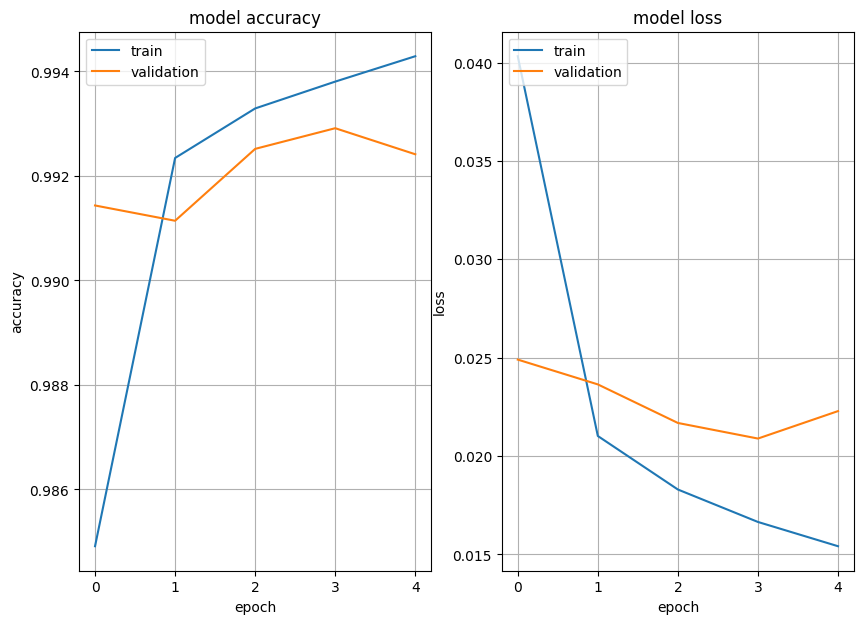

In [43]:
plot_val_accuracy(history_LSTM, save=False, ticks=False)

### Rede Neural Recorrente GRU (Gated Recurrent Unit)
>Entrada (texto) -> Tokenize -> Embedding -> Layers (RNN's/dense) -> Saída (probabilidade da classificação)

In [44]:
# Definindo semenda randômica para ter sempre os mesmos resustados
tf.random.set_seed(42)

# Criando modelo GRU
entrada = layers.Input(shape=(1,), dtype='string')                                    # camada de entrada shape 1 tipo string sendo compatível com a entrada que seria a descrição

camada_tratamento_texto = tokenizer(entrada)                                    # camada de tokenização
camada_tratamento_texto = embedding(camada_tratamento_texto)                          # camada de embedding
camada_tratamento_texto = layers.GRU(64, activation='sigmoid', return_sequences=True)(camada_tratamento_texto) # 'return_sequences=True' para manter shape para a próxima camada
camada_tratamento_texto = layers.GRU(64, activation='sigmoid')(camada_tratamento_texto)  # camada GRU / 64 é o número de neurônios da camada / ativação por sigmoid

saida = layers.Dense(1, activation='sigmoid')(camada_tratamento_texto)                # camada de saída / ativação por sigmoid
modelo_GRU = tf.keras.Model(entrada, saida, name='Modelo_GRU')

# Compilando o modelo
modelo_GRU.compile(loss='binary_crossentropy',                       # para classificação binária (Medicamento / Não Medicamento)
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

# Treinando o modelo
history_GRU = modelo_GRU.fit(x_treino,
                             y_treino,
                             epochs=5,                             # quantidade de iterações a serem feitas para treinar o modelo
                             validation_data=(x_valid,y_valid),    # teste feito durante o treinamento da rede neural para validar as métricas
                             shuffle=True)                         # embaralha a base de treino antes de cada epoch

Epoch 1/5
14536/14536 [==============================] - 293s 20ms/step - loss: 0.0215 - accuracy: 0.9925 - val_loss: 0.0217 - val_accuracy: 0.9926
Epoch 2/5
14536/14536 [==============================] - 286s 20ms/step - loss: 0.0157 - accuracy: 0.9942 - val_loss: 0.0202 - val_accuracy: 0.9928
Epoch 3/5
14536/14536 [==============================] - 287s 20ms/step - loss: 0.0142 - accuracy: 0.9948 - val_loss: 0.0195 - val_accuracy: 0.9931
Epoch 4/5
14536/14536 [==============================] - 301s 21ms/step - loss: 0.0131 - accuracy: 0.9952 - val_loss: 0.0194 - val_accuracy: 0.9929
Epoch 5/5
14536/14536 [==============================] - 292s 20ms/step - loss: 0.0122 - accuracy: 0.9955 - val_loss: 0.0210 - val_accuracy: 0.9930


In [45]:
# Estrutura da rede neural
modelo_GRU.summary()

Model: "Modelo_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 4)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4, 128)            1280000   
                                                                 
 gru (GRU)                   (None, 4, 64)             37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

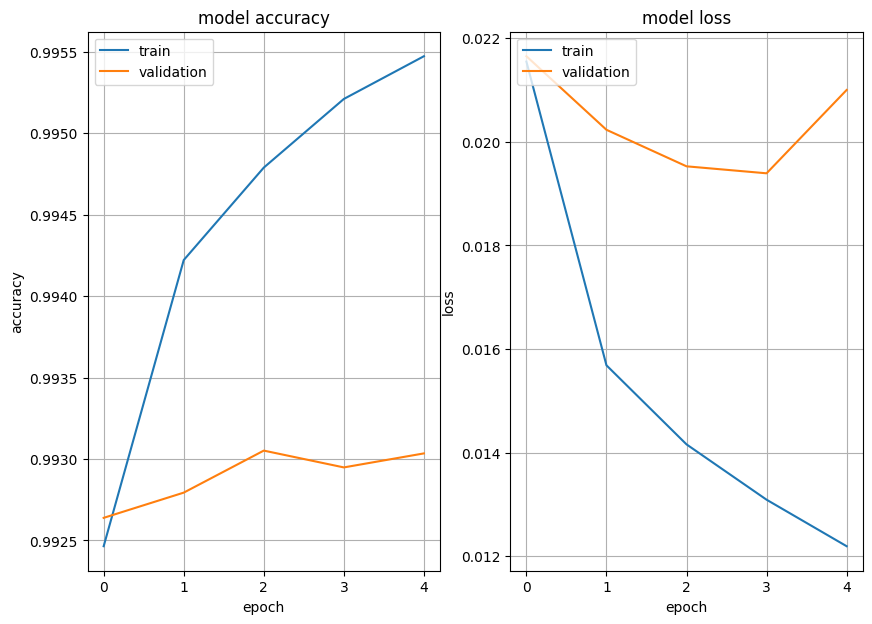

In [46]:
plot_val_accuracy(history_GRU, save=False, ticks=False)

### Rede Neural Recorrente Bidirecional (direita para esquerda e esqueda para direita)
>Entrada (texto) -> Tokenize -> Embedding -> Layers (RNN's/dense) -> Saída (probabilidade da classificação)

#### Bidirecional LSTM

In [47]:
# Definindo semenda randômica para ter sempre os mesmos resustados
tf.random.set_seed(42)

# Criando modelo Bidirecional LSTM
entrada = layers.Input(shape=(1,), dtype='string')                                    # camada de entrada shape 1 tipo string sendo compatível com a entrada que seria a descrição

camada_tratamento_texto = tokenizer(entrada)                                    # camada de tokenização
camada_tratamento_texto = embedding(camada_tratamento_texto)                          # camada de embedding
camada_tratamento_texto = layers.Bidirectional(layers.LSTM(64, activation='sigmoid', return_sequences=True))(camada_tratamento_texto) # 'return_sequences=True' manter shape p/ a próxima camada
camada_tratamento_texto = layers.Bidirectional(layers.LSTM(64, activation='sigmoid'))(camada_tratamento_texto)  # camada GRU / 64 é o número de neurônios da camada / ativação por sigmoid

saida = layers.Dense(1, activation='sigmoid')(camada_tratamento_texto)                # camada de saída / ativação por sigmoid
modelo_BiLSTM = tf.keras.Model(entrada, saida, name='Modelo_Bidirecional_LSTM')

# Compilando o modelo
modelo_BiLSTM.compile(loss='binary_crossentropy',                       # para classificação binária (Medicamento / Não Medicamento)
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

# Treinando o modelo
history_BiLSTM = modelo_BiLSTM.fit(x_treino,
                                   y_treino,
                                   epochs=5,                             # quantidade de iterações a serem feitas para treinar o modelo
                                   validation_data=(x_valid,y_valid),    # teste feito durante o treinamento da rede neural para validar as métricas
                                   shuffle=True)                         # embaralha a base de treino antes de cada epoch

Epoch 1/5
14536/14536 [==============================] - 321s 22ms/step - loss: 0.0206 - accuracy: 0.9925 - val_loss: 0.0236 - val_accuracy: 0.9924
Epoch 2/5
14536/14536 [==============================] - 400s 28ms/step - loss: 0.0153 - accuracy: 0.9944 - val_loss: 0.0210 - val_accuracy: 0.9922
Epoch 3/5
14536/14536 [==============================] - 555s 38ms/step - loss: 0.0139 - accuracy: 0.9949 - val_loss: 0.0201 - val_accuracy: 0.9930
Epoch 4/5
14536/14536 [==============================] - 444s 31ms/step - loss: 0.0130 - accuracy: 0.9952 - val_loss: 0.0201 - val_accuracy: 0.9930
Epoch 5/5
14536/14536 [==============================] - 374s 26ms/step - loss: 0.0124 - accuracy: 0.9954 - val_loss: 0.0214 - val_accuracy: 0.9931


In [48]:
# Estrutura da rede neural
modelo_BiLSTM.summary()

Model: "Modelo_Bidirecional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 4)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4, 128)            1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 4, 128)           98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                          

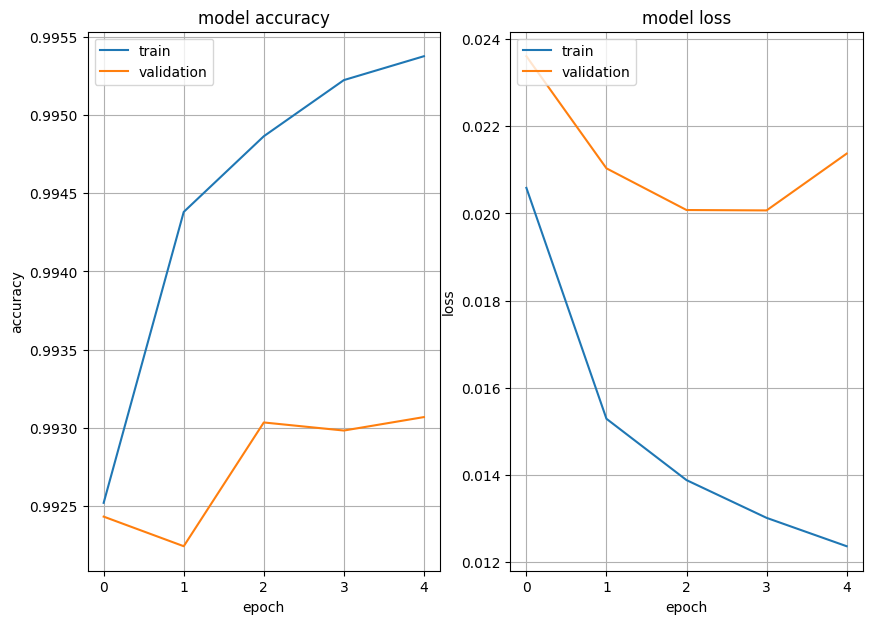

In [49]:
plot_val_accuracy(history_BiLSTM, save=False, ticks=False)

#### Bidirecional GRU

In [50]:
# Definindo semenda randômica para ter sempre os mesmos resustados
tf.random.set_seed(42)

# Criando modelo Bidirecional GRU
entrada = layers.Input(shape=(1,), dtype='string')                                    # camada de entrada shape 1 tipo string sendo compatível com a entrada que seria a descrição

camada_tratamento_texto = tokenizer(entrada)                                    # camada de tokenização
camada_tratamento_texto = embedding(camada_tratamento_texto)                          # camada de embedding
camada_tratamento_texto = layers.Bidirectional(layers.GRU(64, activation='sigmoid', return_sequences=True))(camada_tratamento_texto) # 'return_sequences=True' manter shape p/ a próxima camada
camada_tratamento_texto = layers.Bidirectional(layers.GRU(64, activation='sigmoid'))(camada_tratamento_texto)  # camada GRU / 64 é o número de neurônios da camada / ativação por sigmoid

saida = layers.Dense(1, activation='sigmoid')(camada_tratamento_texto)                # camada de saída / ativação por sigmoid
modelo_BiGRU = tf.keras.Model(entrada, saida, name='Modelo_Bidirecional_GRU')

# Compilando o modelo
modelo_BiGRU.compile(loss='binary_crossentropy',                       # para classificação binária (Medicamento / Não Medicamento)
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

# Treinando o modelo
history_BiGRU = modelo_BiGRU.fit(x_treino,
                                 y_treino,
                                 epochs=5,                             # quantidade de iterações a serem feitas para treinar o modelo
                                 validation_data=(x_valid,y_valid),    # teste feito durante o treinamento da rede neural para validar as métricas
                                 shuffle=True)                         # embaralha a base de treino antes de cada epoch

Epoch 1/5
14536/14536 [==============================] - 456s 31ms/step - loss: 0.0183 - accuracy: 0.9934 - val_loss: 0.0217 - val_accuracy: 0.9931
Epoch 2/5
14536/14536 [==============================] - 370s 25ms/step - loss: 0.0137 - accuracy: 0.9948 - val_loss: 0.0200 - val_accuracy: 0.9931
Epoch 3/5
14536/14536 [==============================] - 432s 30ms/step - loss: 0.0125 - accuracy: 0.9954 - val_loss: 0.0201 - val_accuracy: 0.9931
Epoch 4/5
14536/14536 [==============================] - 428s 29ms/step - loss: 0.0117 - accuracy: 0.9957 - val_loss: 0.0199 - val_accuracy: 0.9932
Epoch 5/5
14536/14536 [==============================] - 443s 30ms/step - loss: 0.0111 - accuracy: 0.9959 - val_loss: 0.0233 - val_accuracy: 0.9929


In [51]:
# Estrutura da rede neural
modelo_BiGRU.summary()

Model: "Modelo_Bidirecional_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 4)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4, 128)            1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 4, 128)           74496     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                           

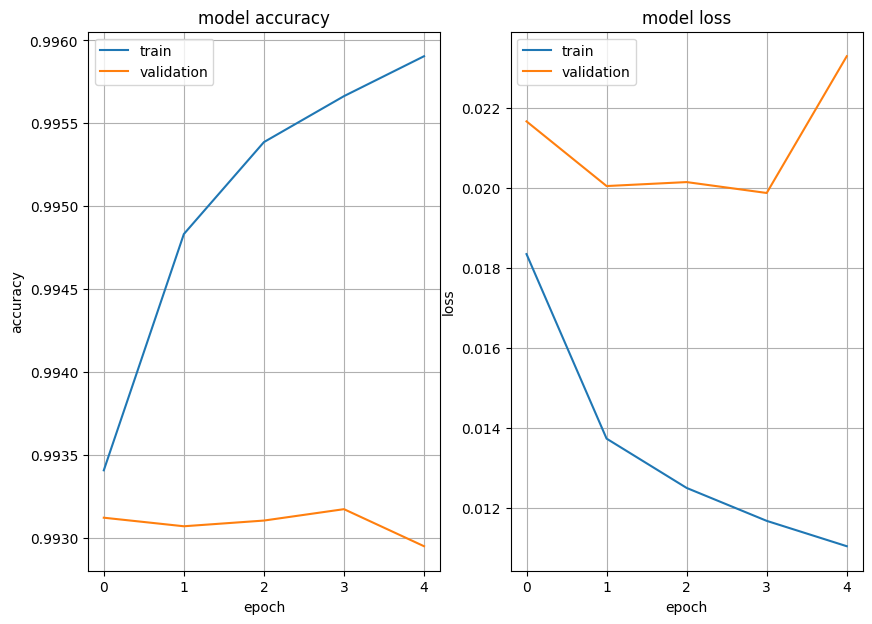

In [52]:
plot_val_accuracy(history_BiGRU, save=False, ticks=False)

### Rede Neural Recorrente Simples (RNN)

In [54]:
# Definindo semenda randômica para ter sempre os mesmos resustados
tf.random.set_seed(42)

# Criando modelo GRU
entrada = layers.Input(shape=(1,), dtype='string')                                    # camada de entrada shape 1 tipo string sendo compatível com a entrada que seria a descrição

camada_tratamento_texto = tokenizer(entrada)                                    # camada de tokenização
camada_tratamento_texto = embedding(camada_tratamento_texto)                          # camada de embedding
camada_tratamento_texto = layers.SimpleRNN(64, activation='sigmoid', return_sequences=True)(camada_tratamento_texto) # 'return_sequences=True' para manter shape para a próxima camada
camada_tratamento_texto = layers.SimpleRNN(64, activation='sigmoid')(camada_tratamento_texto)  # camada SimpleRNN / 64 é o número de neurônios da camada / ativação por sigmoid

saida = layers.Dense(1, activation='sigmoid')(camada_tratamento_texto)                # camada de saída / ativação por sigmoid
modelo_SimpleRNN = tf.keras.Model(entrada, saida, name='Modelo_SimpleRNN')

# Compilando o modelo
modelo_SimpleRNN.compile(loss='binary_crossentropy',                       # para classificação binária (Medicamento / Não Medicamento)
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])

# Treinando o modelo
history_SimpleRNN = modelo_SimpleRNN.fit(x_treino,
                                         y_treino,
                                         epochs=5,                             # quantidade de iterações a serem feitas para treinar o modelo
                                         validation_data=(x_valid,y_valid),    # teste feito durante o treinamento da rede neural para validar as métricas
                                         shuffle=True)                         # embaralha a base de treino antes de cada epoch

Epoch 1/5
14536/14536 [==============================] - 407s 28ms/step - loss: 0.0225 - accuracy: 0.9923 - val_loss: 0.0233 - val_accuracy: 0.9926
Epoch 2/5
14536/14536 [==============================] - 421s 29ms/step - loss: 0.0155 - accuracy: 0.9944 - val_loss: 0.0211 - val_accuracy: 0.9928
Epoch 3/5
14536/14536 [==============================] - 462s 32ms/step - loss: 0.0140 - accuracy: 0.9948 - val_loss: 0.0208 - val_accuracy: 0.9930
Epoch 4/5
14536/14536 [==============================] - 438s 30ms/step - loss: 0.0132 - accuracy: 0.9952 - val_loss: 0.0210 - val_accuracy: 0.9932
Epoch 5/5
14536/14536 [==============================] - 387s 27ms/step - loss: 0.0125 - accuracy: 0.9954 - val_loss: 0.0232 - val_accuracy: 0.9931


In [55]:
# Estrutura da rede neural
modelo_SimpleRNN.summary()

Model: "Modelo_SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 4)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4, 128)            1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 4, 64)             12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                  

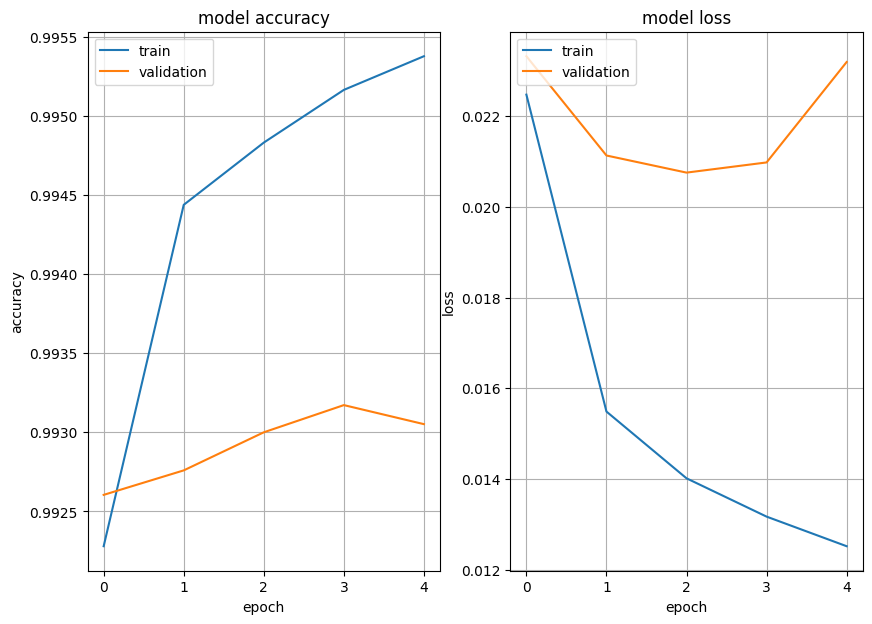

In [56]:
plot_val_accuracy(history_SimpleRNN, save=False, ticks=False)

## Resultado

O melhor resultado foi da LSTM.